# Imports

In [1]:
import numpy as np
import os
from os import listdir as LD, makedirs as MDs
from os.path import join as PJ, basename as PBN, dirname as PDN, exists as PE
import pandas as pd
import shutil as sh
from datetime import datetime as DT
from matplotlib import pyplot as plt

In [2]:
from imod import msw
from imod import mf6

In [3]:
import WS_Mdl.utils as U
import WS_Mdl.utils_imod as UIM

In [4]:
import importlib as IL
IL.reload(U)
IL.reload(UIM)

<module 'WS_Mdl.utils_imod' from 'C:\\Users\\Karam014\\OneDrive - Universiteit Utrecht\\WS_Mdl\\code\\WS_Mdl\\utils_imod.py'>

In [5]:
# import imod
# import imod.util.path
# from imod.formats.prj.prj import open_projectfile_data
# from imod.logging.config import LoggerType
# from imod.logging.loglevel import LogLevel
# from imod.mf6.oc import OutputControl
# from imod.mf6.simulation import Modflow6Simulation
# from imod.mf6.ims import Solution

# Options + Basics

In [6]:
MdlN = 'NBr31'

In [7]:
U.set_verbose(False)

In [8]:
d_Pa = U.get_MdlN_Pa(MdlN)
Pa_PRJ = d_Pa['PRJ']
Dir_PRJ = PDN(Pa_PRJ)
d_INI = U.INI_to_d(d_Pa['INI'])

In [9]:
Xmin, Ymin, Xmax, Ymax = [float(i) for i in d_INI['WINDOW'].split(',')]
# cellsize = float(d_INI['CELLSIZE'])
# N_R, N_C = int( - (Ymin - Ymax) / cellsize ), int( (Xmax - Xmin) / cellsize )

In [10]:
SP_date_1st, SP_date_last = [DT.strftime(DT.strptime(d_INI[f'{i}'], '%Y%m%d'), '%Y-%m-%d') for i in ['SDATE', 'EDATE']]

# Read PRJ

In [11]:
PRJ_content = UIM.read_PRJ_with_OBS(Pa_PRJ)[0]

# Load PRJ

In [12]:
PRJ_, PRJ_OBS = UIM.open_PRJ_with_OBS(Pa_PRJ)

In [13]:
PRJ = PRJ_[0]

In [14]:
period_data = PRJ_[1]

# Load DIS and limit to Mdl Aa

In [15]:
A_BND = PRJ['bnd']['ibound']

In [16]:
# A_BND_init = A_BND.copy()
# A_BND_init.shape

(37, 1126, 1503)

In [17]:
# Subset ibound to the model area of interest (keeping all layers, subsetting x and y)
A_BND_AoI = PRJ['bnd']['ibound'].sel(
    x=slice(Xmin, Xmax),
    y=slice(Ymax, Ymin)  # Note: y is typically decreasing in grid coordinates
)
print(f"Original ibound shape: {A_BND.shape}")
print(f"Subsetted ibound shape: {A_BND_AoI.shape}")
A_BND_AoI

Original ibound shape: (37, 1126, 1503)
Subsetted ibound shape: (37, 86, 120)


<xarray.DataArray (layer: 37, y: 86, x: 120)> Size: 3MB
dask.array<getitem, shape=(37, 86, 120), dtype=float64, chunksize=(1, 86, 120), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 960B 1.132e+05 1.132e+05 ... 1.25e+05 1.25e+05
  * y        (y) float64 688B 3.962e+05 3.96e+05 ... 3.878e+05 3.876e+05
    dx       float64 8B 100.0
    dy       float64 8B -100.0
  * layer    (layer) int64 296B 1 2 3 4 5 6 7 8 9 ... 29 30 31 32 33 34 35 36 37

In [18]:
# Create a boolean mask for the first/last row and column
is_first_last_col = (A_BND_AoI.coords['x'] == A_BND_AoI.x[0]) | (A_BND_AoI.coords['x'] == A_BND_AoI.x[-1])
is_first_last_row = (A_BND_AoI.coords['y'] == A_BND_AoI.y[0]) | (A_BND_AoI.coords['y'] == A_BND_AoI.y[-1])

# Combine the masks. This creates a 2D mask that broadcasts over the 'layer' dimension.
is_border = is_first_last_col | is_first_last_row

# Use where to set border cells to -1, keeping original values elsewhere.
A_BND_AoI = A_BND_AoI.where(~is_border, -1)
A_BND_AoI

<xarray.DataArray (layer: 37, y: 86, x: 120)> Size: 3MB
dask.array<where, shape=(37, 86, 120), dtype=float64, chunksize=(1, 86, 120), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 960B 1.132e+05 1.132e+05 ... 1.25e+05 1.25e+05
  * y        (y) float64 688B 3.962e+05 3.96e+05 ... 3.878e+05 3.876e+05
    dx       float64 8B 100.0
    dy       float64 8B -100.0
  * layer    (layer) int64 296B 1 2 3 4 5 6 7 8 9 ... 29 30 31 32 33 34 35 36 37

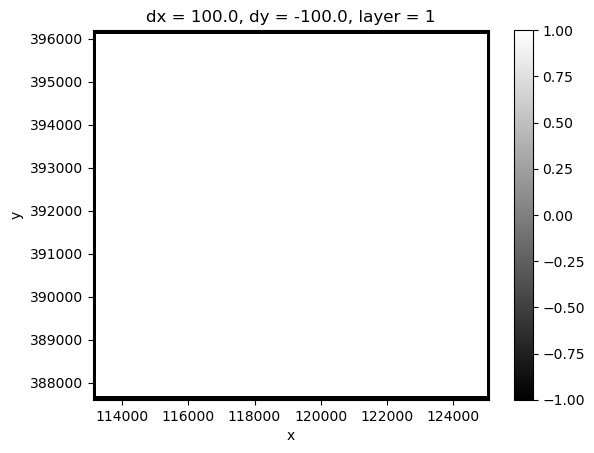

In [19]:
A_BND_AoI.isel(layer=0).plot.imshow(cmap='grey')

Ok, the borders have been set to -1.

In [20]:
PRJ['bnd']['ibound'] = A_BND_AoI # Update the ibound in the project

In [21]:
# PRJ['bnd']['ibound'] = A_BND_init # Update the ibound in the project

In [22]:
UIM.xr_describe(PRJ['bnd']['ibound'].sel(layer=1))

--- Statistics for: DataArray ---
count    10320.000000
mean         0.920930
std          0.389727
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: DataArray, dtype: float64

--- Coordinate Summary ---
- x (float64):
count       120.0
min      113150.0
max      125050.0
step        100.0

- y (float64):
count        86.0
min      387650.0
max      396150.0
step       -100.0

------------------------------


# Load MF6 Mdl

In [23]:
times = pd.date_range(SP_date_1st, SP_date_last, freq='D')

In [24]:
# Convert IMOD5 to MODFLOW6 (without CAP package due to mixed grid issues)
PRJ_no_MSW = PRJ.copy()
PRJ_CAP = {}
if "cap" in PRJ_no_MSW:
    PRJ_CAP['cap'] = PRJ_no_MSW["cap"]
    PRJ_CAP['extra'] = PRJ_no_MSW['extra']
    del PRJ_no_MSW["cap"], PRJ_no_MSW['extra']
    print("Removed CAP package due to mixed grid compatibility issues")

Sim_MF6 = mf6.Modflow6Simulation.from_imod5_data(PRJ_no_MSW, period_data, times) #, regridder_types=)
print("Simulation created successfully!")

Removed CAP package due to mixed grid compatibility issues
Simulation created successfully!


In [25]:
MF6_Mdl = Sim_MF6['imported_model']

In [26]:
MF6_Mdl["oc"] = mf6.OutputControl(save_head="last", save_budget="last")
    
# Mimic iMOD5's "Moderate" settings
IMS = mf6.Solution(
    modelnames=["imported_model"],
    print_option="summary",
    outer_csvfile=None,
    inner_csvfile=None,
    no_ptc=None,
    outer_dvclose=0.001,
    outer_maximum=150,
    under_relaxation="dbd",
    under_relaxation_theta=0.9,
    under_relaxation_kappa=0.0001,
    under_relaxation_gamma=0.0,
    under_relaxation_momentum=0.0,
    backtracking_number=0,
    backtracking_tolerance=0.0,
    backtracking_reduction_factor=0.0,
    backtracking_residual_limit=0.0,
    inner_maximum=30,
    inner_dvclose=0.001,
    inner_rclose=100.0,
    rclose_option="strict",
    linear_acceleration="bicgstab",
    relaxation_factor=0.97,
    preconditioner_levels=0,
    preconditioner_drop_tolerance=0.0,
    number_orthogonalizations=0,
)
Sim_MF6["ims"] = IMS

MetaSWAP (MSW) needed to be removed, otherwise this function fails.

## Check MF6 params

In [27]:
if False:
    for k in MF6_Mdl.keys():
        print(f" ***** {k} ***** ")
        UIM.xr_describe(MF6_Mdl['sto'].dataset)
        print("*****************************************************")

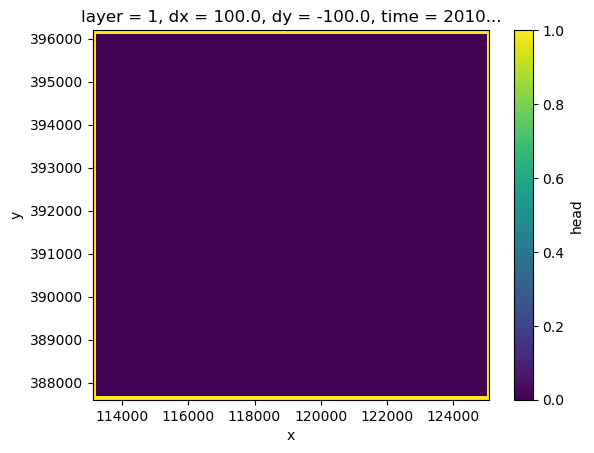

In [28]:
(~np.isnan(MF6_Mdl['chd_merged'].dataset['head'].isel(time=0, layer=0))).plot.imshow()

Ok, CHD is set only at the border as expected. Let's check a few more params though, to be safe.

In [64]:
# MF6_Mdl['dis'].dataset['top'].plot.imshow(cmap='terrain')

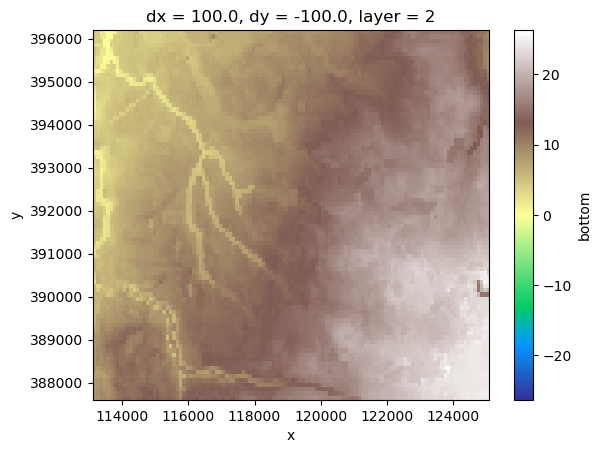

In [51]:
# MF6_Mdl['dis'].dataset['bottom'].sel(layer=2).plot.imshow(cmap='terrain')

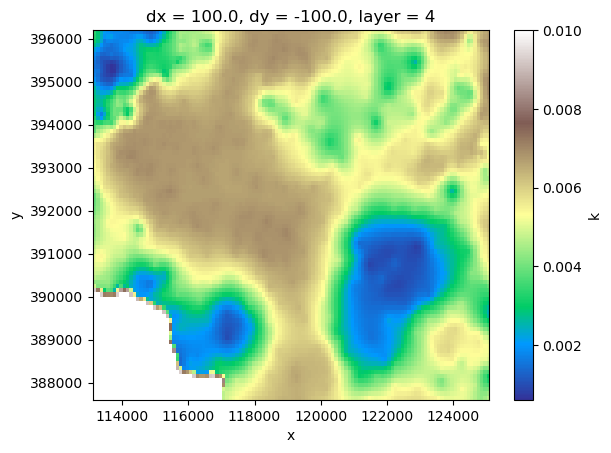

In [63]:
# MF6_Mdl['npf'].dataset['k'].sel(layer=4).plot.imshow(cmap='terrain')

All those we've checked make sense for now.

# Load MSW

## 1st attempt

In [65]:
MF6_DIS = Sim_MF6["imported_model"]["dis"]

In [66]:
try:
    MSW_Mdl = msw.MetaSwapModel.from_imod5_data(PRJ_CAP, MF6_DIS, times)
    print("🎉 MetaSwap model created successfully!")
except Exception as e:
    print(f"Error creating MetaSwap model: {e}")
    MSW_Mdl = None

Error creating MetaSwap model: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'x' ('x',)


## 2nd attempt

### Regriding
Match dimensions of MetaSwap model with MF6 model

Dimensions of MF6_DIS and MetaSWAP files do not align. Former is 100x100, latter is 25x25 m.

In [79]:
# Debug the grid alignment issue
print("=== Target Discretization ===")
print(f"Type: {type(MF6_DIS)}")
print(f"Keys: {list(MF6_DIS.keys()) if hasattr(MF6_DIS, 'keys') else 'No keys method'}")

=== Target Discretization ===
Type: <class 'imod.mf6.dis.StructuredDiscretization'>
Keys: No keys method


In [80]:
# Access the data from MF6_DIS
if hasattr(MF6_DIS, 'dataset'):
    print(f"Dataset keys: {list(MF6_DIS.dataset.keys())}")
    x_MF6 = MF6_DIS.dataset.x.values
    y_MF6 = MF6_DIS.dataset.y.values
else:
    # Try accessing as a dataset directly
    x_MF6 = MF6_DIS.x.values
    y_MF6 = MF6_DIS.y.values

Dataset keys: ['idomain', 'top', 'bottom']


In [81]:
print(f"Target X range: {x_MF6.min()} to {x_MF6.max()}, length: {len(x_MF6)}")
print(f"Target Y range: {y_MF6.min()} to {y_MF6.max()}, length: {len(y_MF6)}")

Target X range: 113150.0 to 125050.0, length: 120
Target Y range: 387650.0 to 396150.0, length: 86


In [82]:
print("\n=== CAP Data ===")
sample_cap = PRJ_CAP['cap']['urban_area']
x_MSW = sample_cap.x.values
y_MSW = sample_cap.y.values
print(f"CAP X range: {x_MSW.min()} to {x_MSW.max()}, length: {len(x_MSW)}")
print(f"CAP Y range: {y_MSW.min()} to {y_MSW.max()}, length: {len(y_MSW)}")

print(f"\n=== Comparison ===")
print(f"X grids compatible: {len(x_MF6) == len(x_MSW) and np.allclose(x_MF6, x_MSW)}")
print(f"Y grids compatible: {len(y_MF6) == len(y_MSW) and np.allclose(y_MF6, y_MSW)}")


=== CAP Data ===
CAP X range: 60012.5 to 210287.5, length: 6012
CAP Y range: 322512.5 to 435087.5, length: 4504

=== Comparison ===
X grids compatible: False
Y grids compatible: False


In [83]:
# # Remove 'extra' from cap if it exists (to avoid isel error on metadata)
# if 'extra' in PRJ_CAP['cap'].keys():
#     PRJ_CAP['cap']['extra']

In [84]:
# Get the MODFLOW6 extent (target domain)
x_MF6_min, x_MF6_max = MF6_DIS.dataset.x.min().item(), MF6_DIS.dataset.x.max().item()
y_MF6_min, y_MF6_max = MF6_DIS.dataset.y.min().item(), MF6_DIS.dataset.y.max().item()
print(f"MODFLOW6 domain: X({x_MF6_min:.1f} to {x_MF6_max:.1f}), Y({y_MF6_min:.1f} to {y_MF6_max:.1f})")

MODFLOW6 domain: X(113150.0 to 125050.0), Y(387650.0 to 396150.0)


In [85]:
# Get CAP grid info
MSW_sample = PRJ_CAP['cap']['urban_area']
dx_MSW = abs(MSW_sample.x.values[1] - MSW_sample.x.values[0])  # CAP resolution (absolute value)
dy_MSW = abs(MSW_sample.y.values[1] - MSW_sample.y.values[0])  # CAP resolution (absolute value)
print(f"CAP grid resolution: dx={dx_MSW:.1f}m, dy={dy_MSW:.1f}m")

CAP grid resolution: dx=25.0m, dy=25.0m


In [ ]:
# Create exact coordinates for the refined grid within MODFLOW6 domain
refined_x = np.arange( (x_MF6_min - dx_MF6/2 + cap_dx/2) , MF6_x_max, cap_dx)
refined_y = np.arange(MF6_y_max + cap_dy*3/2, MF6_y_min, -cap_dy)
print(f"Refined grid: x from {refined_x.min():.1f} to {refined_x.max():.1f} ({len(refined_x)} cells)")
print(f"Refined grid: y from {refined_y.min():.1f} to {refined_y.max():.1f} ({len(refined_y)} cells)")

In [ ]:
# Create exact coordinates for the refined grid within MODFLOW6 domain
refined_x = np.arange(MF6_x_min - cap_dx*3/2, MF6_x_max, cap_dx)
refined_y = np.arange(MF6_y_max + cap_dy*3/2, MF6_y_min, -cap_dy)
print(f"Refined grid: x from {refined_x.min():.1f} to {refined_x.max():.1f} ({len(refined_x)} cells)")
print(f"Refined grid: y from {refined_y.min():.1f} to {refined_y.max():.1f} ({len(refined_y)} cells)")              

In [ ]:
# Create a refined target discretization
MF6_DIS_refined = MF6_DIS.dataset.interp(
    x=refined_x,
    y=refined_y,
    method='linear'
)

In [ ]:
MF6_DIS_refined['idomain'] = MF6_DIS_refined['idomain'].astype(int)

In [ ]:
MF6_DIS_refined.sel(layer=1).plot.i

In [ ]:
# Convert back to StructuredDiscretization
MF6_DIS = mf6.StructuredDiscretization(
    idomain=MF6_DIS_refined['idomain'],
    top=MF6_DIS_refined['top'],
    bottom=MF6_DIS_refined['bottom']
)
print(f"Refined MF6_DIS shape: {MF6_DIS.dataset.sizes}")

In [ ]:
# Now regrid all CAP data to the exact refined coordinates
PRJ_CAP_regridded = {'cap': {}}
for key, data in PRJ_CAP['cap'].items():
    print(f"Processing {key}: dims = {data.dims}")
    
    # Check if data has spatial dimensions (x, y)
    if 'x' in data.dims and 'y' in data.dims:
        if key == 'wetted_area':
            # For area-related fields, we need to preserve the total area
            # The wetted_area represents the actual area, which should remain as cell area
            regridded_data = data.interp(x=refined_x, y=refined_y, method='nearest')
            # Set to full cell area (25m x 25m = 625 m²)
            PRJ_CAP_regridded['cap'][key] = regridded_data * 0 + (cap_dx * cap_dy)
        else:
            # For other spatial data, interpolate normally
            PRJ_CAP_regridded['cap'][key] = data.interp(
                x=refined_x,
                y=refined_y,
                method='nearest'
            )
    else:
        # Keep non-spatial data as is
        PRJ_CAP_regridded['cap'][key] = data
print("CAP data regridding completed.")

In [ ]:
# Merge with extra metadata
PRJ_CAP_for_MSW = {**PRJ_CAP_regridded, **{'extra': {**PRJ_CAP['extra']}}}

### Fix mete_grid.inp relative paths
MSW.MetaSwapModel.from_imod5_data is struggling with relative paths, so we'll convert them to full paths. #666 caution, if they're already full paths, this may cause an error.

In [ ]:
# Get the original mete_grid.inp file path
Pa_mete_grid = PRJ_CAP['extra']['paths'][2][0]  # 3rd file (index 2) (by design in imod - i.e. the order can't change)
print(f"Original file: {Pa_mete_grid}")

In [ ]:
# Load mete_grid, edit and save it 
Dir_mete_grid = PDN(Pa_mete_grid)
Pa_mete_grid_AbsPa = PJ( PDN(Pa_mete_grid), 'temp', 'mete_grid.inp')
if not PE(PDN(Pa_mete_grid_AbsPa)):
    MDs(PDN(Pa_mete_grid_AbsPa))

DF = pd.read_csv(Pa_mete_grid, header=None, names=['N', 'Y', 'P', 'PET'])
DF.P = DF.P.apply(lambda x: os.path.abspath( PJ(Dir_PRJ, x) ))
DF.PET = DF.PET.apply(lambda x: os.path.abspath( PJ(Dir_PRJ, x) ))  # Fixed: was DF.P instead of DF.PET

In [ ]:
# Write CSV with proper format to avoid imod parsing issues with newlines
# imod doesn't strip newlines from paths, so we need to format carefully
corrected_lines = []
for index, row in DF.iterrows():
    # Add quotes around paths like the original format
    line = f'{row["N"]},{row["Y"]},"{row["P"]}","{row["PET"]}"'
    corrected_lines.append(line)

# Write without newlines in path columns
with open(Pa_mete_grid_AbsPa, 'w') as f:
    for i, line in enumerate(corrected_lines):
        if i == len(corrected_lines) - 1:  # Last line - no newline
            f.write(line)
        else:
            f.write(line + '\n')

print(f"Created corrected mete_grid.inp: {Pa_mete_grid_AbsPa}") 

In [ ]:
# Replace the mete_grid.inp path in the PRJ_CAP_for_MSW dictionary
PRJ_CAP_for_MSW['extra']['paths'][2][0] = Pa_mete_grid_AbsPa

### Finally load MS Sim

In [ ]:
# Create the MetaSwap model
MSW_Mdl = MSW.MetaSwapModel.from_imod5_data(PRJ_CAP_for_MSW, MF6_DIS, times)
print("🎉 MetaSwap model created successfully!")

# Connect MF6 to MetaSWAP

## Clip models

In [ ]:
Sim_MF6_AoI = Sim_MF6.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)
MSW_Mdl_AoI = MSW_Mdl.clip_box(x_min=Xmin, x_max=Xmax, y_min=Ymin, y_max=Ymax)

#### Sense check

In [ ]:
Xmin, Xmax, Ymin, Ymax

In [ ]:
MF6_Mdl_AoI = Sim_MF6_AoI['imported_model']

In [ ]:
MF6_Mdl_AoI['dis']['x'].min().values, MF6_Mdl_AoI['dis']['x'].max().values, \
MF6_Mdl_AoI['dis']['y'].min().values, MF6_Mdl_AoI['dis']['y'].max().values

Makes sense as those are cell centers. (dx=dy=100m)

## Load models into memory

In [ ]:
for pkg in MF6_Mdl_AoI.values():
    pkg.dataset.load()

for pkg in MSW_Mdl_AoI.values():
    pkg.dataset.load()

## Cleanup

### MF6

In [ ]:
mask = MF6_Mdl_AoI.domain

In [ ]:
mask.sel({'layer':5}).plot.imshow( #111 Just to check the mask
    cmap='gray')

In [ ]:
Sim_MF6_AoI.mask_all_models(mask)
DIS_AoI = MF6_Mdl_AoI["dis"]

### Check if IMS has changed after clipping

In [ ]:
Sim_MF6['ims'] == Sim_MF6_AoI['ims']

In [ ]:
IMS_AoI = Sim_MF6_AoI['ims']
IMS_AoI_Vars = [attr for attr in dir(IMS_AoI) if not attr.startswith('_') and not callable(getattr(IMS_AoI, attr))]
IMS_Vars = [attr for attr in dir(IMS) if not attr.startswith('_') and not callable(getattr(IMS, attr))]
for var in IMS_AoI_Vars:
    if getattr(IMS_AoI, var) != getattr(IMS, var):
        print(f"{var}: \n{getattr(IMS_AoI, var)}\n{getattr(IMS, var)}")

False shows it's changed, but I don't see anything different.

In [ ]:
IMS.dataset.equals(IMS_AoI.dataset)

This confirms the settings are identical. It's just that clipping creates a new object hash, that's why == didn't show True.

### Check if the packages are the same

In [ ]:
MF6_Mdl.keys() == MF6_Mdl_AoI.keys()

In [ ]:
# Detailed comparison of MF6 model packages
print("=== MF6 Model Package Comparison ===")

# Get the keys from both models
original_keys = set(MF6_Mdl.keys())
aoi_keys = set(MF6_Mdl_AoI.keys())

print(f"Original model packages: {len(original_keys)}")
print(f"AoI model packages: {len(aoi_keys)}")

# Find differences
only_in_original = original_keys - aoi_keys
only_in_aoi = aoi_keys - original_keys
common_keys = original_keys & aoi_keys

print(f"\nPackages only in original model ({len(only_in_original)}):")
for key in sorted(only_in_original):
    print(f"  - {key}")

print(f"\nPackages only in AoI model ({len(only_in_aoi)}):")
for key in sorted(only_in_aoi):
    print(f"  - {key}")

print(f"\nCommon packages ({len(common_keys)}):")
for key in sorted(common_keys):
    print(f"  - {key}")

# Check if it's just an ordering issue
print(f"\nSame packages (different order): {original_keys == aoi_keys}")
print(f"Original keys (ordered): {sorted(original_keys)}")
print(f"AoI keys (ordered): {sorted(aoi_keys)}")

In [ ]:
# Check if the difference is related to the masking operation
print("\n=== Impact of Masking Operation ===")

# The masking operation (Sim_MF6_AoI.mask_all_models(mask)) might have removed some packages
# that are entirely outside the domain or have no active cells after masking

# Let's check if any packages were removed due to masking
print("Note: The masking operation might remove packages that have no active cells in the AoI")

# Check for specific package types that are commonly affected by clipping/masking
potentially_affected = ['wel', 'drn', 'riv', 'ghb', 'chd', 'rch', 'evt']
for pkg_type in potentially_affected:
    orig_matches = [k for k in original_keys if pkg_type in k.lower()]
    aoi_matches = [k for k in aoi_keys if pkg_type in k.lower()]
    
    if len(orig_matches) != len(aoi_matches):
        print(f"\n{pkg_type.upper()} packages:")
        print(f"  Original: {orig_matches}")
        print(f"  AoI: {aoi_matches}")
        print(f"  Difference: {len(orig_matches) - len(aoi_matches)} packages removed")

# Check the masking operation that was performed
print(f"\nMask shape: {mask.shape if hasattr(mask, 'shape') else 'No shape attribute'}")
print(f"Mask type: {type(mask)}")

# Count active cells in mask
try:
    if hasattr(mask, 'values'):
        active_cells = (mask.values > 0).sum()
        total_cells = mask.values.size
        print(f"Active cells in mask: {active_cells}/{total_cells} ({100*active_cells/total_cells:.1f}%)")
except:
    print("Could not compute active cell statistics")

In [ ]:
MF6_Mdl['chd_merged'].dataset['head'].sel(time='2010-01-01', layer=1).plot.imshow()

** CHD is not plotting properly. We need to check if the input files have been read properly in more regular interval **

### MSW

In [ ]:
MF6_Mdl.keys()

In [ ]:
for Pkg in MF6_Mdl_AoI.keys():
    print(Pkg)

In [ ]:
# Cleanup MetaSWAP
msw_model_clipped["grid"].dataset["rootzone_depth"] = msw_model_clipped["grid"].dataset["rootzone_depth"].fillna(1.0)

import primod

metamod_coupling = primod.MetaModDriverCoupling(mf6_model="imported_model", mf6_recharge_package="msw-rch", mf6_wel_package="msw-sprinkling")
metamod = primod.MetaMod(msw_model_clipped, simulation_clipped, coupling_list=[metamod_coupling])

metamod.write(out_dir, "modflow6_dll", "metaswap_dll", "metaswap_dll_dependency", modflow6_write_kwargs={"binary": False})


# Write Simulation

In [ ]:
Sim_MF6_AoI.mask_all_models(mask)

In [ ]:
Dir_Sim = d_Pa['Pa_MdlN']

In [ ]:
os.makedirs(Dir_Sim, exist_ok=True)

In [ ]:
from imod.schemata import ValidationError

with imod.util.print_if_error(ValidationError):
    MF6_Sim.write(Dir_Sim)  # Attention: this will fail!

# Junkyard

In [ ]:
stop

#### Test sim without cap

 <!-- # Simple solution: Remove CAP package and test if conversion works
 print("=== Testing Without CAP Package ===")

 # Create a copy of PRJ without the CAP package
 PRJ_no_MSW = PRJ.copy()
 if "cap" in PRJ_no_MSW:
     del PRJ_no_MSW["cap"]
     print("CAP package removed from PRJ")
 else:
     print("CAP package not found in PRJ")

 print(f"Original PRJ keys: {list(PRJ.keys())}")
 print(f"PRJ without CAP keys: {list(PRJ_no_MSW.keys())}")

 # Test the conversion without CAP
 try:
     print("\n=== Testing Simulation Conversion Without CAP ===")
     simulation = imod.MF6.Modflow6Simulation.from_imod5_data(PRJ_no_MSW, period_data, times)
     print("SUCCESS: Simulation created without CAP package!")
     print(f"Simulation keys: {list(simulation.keys())}")
    
     # Check what packages were created
     if "imported_model" in simulation:
         model = simulation["imported_model"]
         print(f"Model packages: {list(model.keys())}")
        
 except Exception as e:
     print(f"Error without CAP: {e}")
     import traceback
     traceback.print_exc() -->

#### Investigate well error

from imod.MF6.wel import LayeredWell, Well

PRJ['wel-WEL_Br_Wa_T_NBr1']['layer']

Well.from_imod5_data('wel-WEL_Br_Wa_T_NBr1', PRJ, times)

os.remove(Pa_PRJ_temp)  # Delete temp PRJ file as it's not needed anymore.

## Option: Subset PRJ data before conversion

You can subset the PRJ data before calling `from_imod5_data` to reduce memory usage and processing time.

In [ ]:
# Example: Subset PRJ data before conversion to reduce memory usage
# This approach can be useful for very large models

def subset_prj_data(prj_dict, x_min, x_max, y_min, y_max):
    """
    Subset PRJ data to a specific bounding box before conversion.
    
    Parameters:
    -----------
    prj_dict : dict
        The PRJ dictionary from open_projectfile_data
    x_min, x_max, y_min, y_max : float
        Bounding box coordinates
    """
    prj_subset = {}
    
    for package_name, package_data in prj_dict.items():
        if hasattr(package_data, 'sel') and hasattr(package_data, 'dims'):
            # For xarray DataArrays with spatial dimensions
            if 'x' in package_data.dims and 'y' in package_data.dims:
                try:
                    # Subset to bounding box
                    subset_data = package_data.sel(
                        x=slice(x_min, x_max),
                        y=slice(y_max, y_min)  # Note: y is typically decreasing
                    )
                    prj_subset[package_name] = subset_data
                    print(f"Subsetted {package_name}: {package_data.sizes} -> {subset_data.sizes}")
                except Exception as e:
                    # If subsetting fails, keep original data
                    prj_subset[package_name] = package_data
                    print(f"Could not subset {package_name}: {e}")
            else:
                # Keep non-spatial data as is
                prj_subset[package_name] = package_data
        else:
            # Keep non-xarray data as is
            prj_subset[package_name] = package_data
    
    return prj_subset

# Example usage (commented out - use if needed):
# PRJ_subset = subset_prj_data(PRJ, Xmin, Xmax, Ymin, Ymax)
# Sim_MF6_subset = imod.mf6.Modflow6Simulation.from_imod5_data(PRJ_subset, period_data, times)

## Alternative: Check if iMOD-python supports direct spatial selection

Some iMOD functions may support direct spatial selection during reading. Check the documentation for your specific iMOD-python version.